## Day 83 Lecture 2 Assignment

In this assignment, we will learn about Spark and MLLib.




Update the Google Compute Engine.

In [55]:
! apt-get update

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http

Run the cells below to start a spark session.

In [56]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz

Set up the environmental variables.

In [57]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

Install Pyspark. ***Note: The version must match the version of Spark that you have installed earlier***.

In [58]:
!pip install -q findspark
!pip install pyspark==2.4.6

Download and save the video games sales CSV file to your Colab Data folder on Google Drive. 

The file can be downloaded from link [here](https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Big%20Data/Video_Games_Sales_as_at_22_Dec_2016.csv), download it and save it to your Google Colab Data folder on gdrive.


Mount your Google drive for access in Google Colab Notebooks.

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Change your directory to the Colab Data folder where you saved the CSV file.

In [60]:
os.chdir('/content/gdrive/MyDrive/Thinkful/Data')

Set your local session.

In [61]:
APP_NAME = "Day83"
SPARK_URL = "local[*]"

Run the cells below to start a spark session.

In [62]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

List all the files in your directory.

In [63]:
# Answer below:
os.getcwd()


'/content/gdrive/MyDrive/Thinkful/Data'

Load the CSV file as a Spark dataframe.

In [64]:
video = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Video_Games_Sales_as_at_22_Dec_2016.csv")

Review the data by applying the show command.

In [65]:
# Answer below:
video.show()

+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+-------------------+------+
|                Name|Platform|Year_of_Release|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|          Developer|Rating|
+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+-------------------+------+
|          Wii Sports|     Wii|           2006|      Sports|            Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|          76|          51|         8|       322|           Nintendo|     E|
|   Super Mario Bros.|     NES|           1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|        null|        null|     

We will predict global sales using a number of variables in this dataset. We will start by removing all missing data (though we know that this will make the dataset significantly smaller). Drop all the missing values using dropna.

In [66]:
# Answer below:
video = video.dropna()


Get the unique values for Genre.


In [67]:
distinct_g = [x.Genre for x in video.select('Genre').distinct().collect()]
len(distinct_g)

12

Next, we will create dummy variables for the genre. Create these variables using the `OneHotEncoder` provided in spark.

In [68]:
# Answer below:


from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCol="Genre", outputCol="GenreIndex")
model = stringIndexer.fit(video)
indexed = model.transform(video)
encoder = OneHotEncoder( inputCol="GenreIndex", outputCol="GenreVec")
encoded = encoder.transform(indexed)


In [69]:
encoded.show()

+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+
|                Name|Platform|Year_of_Release|   Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|           Developer|Rating|GenreIndex|      GenreVec|
+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+
|          Wii Sports|     Wii|           2006|  Sports|            Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|          76|          51|         8|       322|            Nintendo|     E|       1.0|(11,[1],[1.0])|
|      Mario Kart Wii|     Wii|           2008|  Racing|            Nint

Convert the critic score and the user score to a number between 0 and 1 by dividing by 100. 

In [70]:
# Answer below:

from pyspark.sql.functions import lit, col

video = encoded.withColumn('critic_percent', video['Critic_Score'] / lit(100))

In [71]:
video_percent = video.withColumn('user_percent', video['User_Score'] / lit(100))
video_percent.show()

+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+--------------+-------------------+
|                Name|Platform|Year_of_Release|   Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|           Developer|Rating|GenreIndex|      GenreVec|critic_percent|       user_percent|
+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+--------------+-------------------+
|          Wii Sports|     Wii|           2006|  Sports|            Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|          76|          51|         8|       322|            Nintendo| 

Using the vector assembler, create a vector of features using the scaled user score, the scaled critic score and the one hot encoded vector.

In [72]:
# Answer below:

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

feature_cols = ['user_percent', 'critic_percent', 'GenreVec']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

X = assembler.transform(video_percent)
X.show()


+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+--------------+-------------------+--------------------+
|                Name|Platform|Year_of_Release|   Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|           Developer|Rating|GenreIndex|      GenreVec|critic_percent|       user_percent|            features|
+--------------------+--------+---------------+--------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+--------------+--------------+-------------------+--------------------+
|          Wii Sports|     Wii|           2006|  Sports|            Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|       

Split the data into 70% in the training sample and 30% in the test sample.

In [73]:
# Answer below:
train, test = X.randomSplit([0.7, 0.3], seed=1) # train_test_split
train.show()


+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+---------------+--------------+--------------------+--------------------+
|                Name|Platform|Year_of_Release|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|           Developer|Rating|GenreIndex|       GenreVec|critic_percent|        user_percent|            features|
+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+--------------------+------+----------+---------------+--------------+--------------------+--------------------+
|   Tales of Xillia 2|     PS3|           2012|Role-Playing|  Namco Bandai Games|     0.2|    0.12|    0.45|       0.0

## Linear Regression

Using the train and test data, generate a linear regression to predict global sales. Print the r squared from the model summary.

In [74]:
# Answer below:

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='Global_Sales')

# Fit the model
lrModel = lr.fit(train)

# Summarize the model over the training set and print out some metrics
lrModel.summary.r2

0.061834142107681456

Calculate the RMSE

In [75]:
lrModel.summary.rootMeanSquaredError

2.085580280038145

## Classification - Binomial Logistic Regression

Download and save the college admission  CSV file to your Colab Data folder on Google Drive. 

The file can be downloaded from link [here](https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Admission_Predict.csv), download it and save it to your Google Colab Data folder on gdrive.

Load the admit CSV file in to the spark instance.

In [76]:
# Answer below:
admit = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Admission_Predict.csv")
admit.show()

+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|
|         6|      330|        115|                5|4.5| 3.0|9.34|       1|             0.9|
|         7|      321|        109|                3|3.0| 4.0| 8.2|       1|            0.75|
|         8|      308|        101|                2|3.0| 4.0| 7.9|    

In [77]:
admit.printSchema()

root
 |-- Serial No.: integer (nullable = true)
 |-- GRE Score: integer (nullable = true)
 |-- TOEFL Score: integer (nullable = true)
 |-- University Rating: integer (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR : double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: integer (nullable = true)
 |-- Chance of Admit : double (nullable = true)



Create a categorical response from `Chance of Admit` column.

In [78]:
from pyspark.ml.feature import Binarizer
# Answer below
binarizer = Binarizer(threshold=0.5, inputCol="Chance of Admit ", outputCol="admittable")
binarizedDataFrame = binarizer.transform(admit)

Divide GRE and TOEFL score columns by 100 to normalize the features.

In [83]:
from pyspark.sql.functions import lit, col
# Answer below
admit_norm = binarizedDataFrame.withColumn('GRE_Norm', admit['GRE Score'] / lit(100))
admit = admit_norm.withColumn('TOEFL_Norm', admit['TOEFL Score'] / lit(100))

Vectorize the features using the vector assembler, saving them into a column named features.

In [84]:
# Answer below
feature_cols = ['GRE_Norm', 'TOEFL_Norm']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

X = assembler.transform(admit)
X.show()

+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |admittable|GRE_Norm|TOEFL_Norm|   features|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|       1.0|    3.37|      1.18|[3.37,1.18]|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|       1.0|    3.24|      1.07|[3.24,1.07]|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|       1.0|    3.16|      1.04|[3.16,1.04]|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|       1.0|    3.22|       1.1| [3.22,1.1]|
|         5|      314|        103|              

Split into train and test subsets.

In [85]:
# Answer below:
train, test = X.randomSplit([0.7, 0.3], seed=1) # train_test_split
train.show()


+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |admittable|GRE_Norm|TOEFL_Norm|   features|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|       1.0|    3.37|      1.18|[3.37,1.18]|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|       1.0|    3.24|      1.07|[3.24,1.07]|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|       1.0|    3.16|      1.04|[3.16,1.04]|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|       1.0|    3.22|       1.1| [3.22,1.1]|
|         6|      330|        115|              

Define the Logistic regression model.

In [86]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='admittable')


Fit the model.

In [91]:
# Answer below
logrModel = logr.fit(train)

predict in the test set.

In [92]:
# Answer below
predictions = logrModel.transform(test)

Plot the ROC.

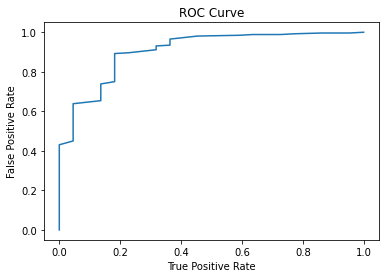

Training set areaUnderROC: 0.9062937062937064


In [94]:
import matplotlib.pyplot as plt

trainingSummary = logrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Calculate the overall model accuracy using the model evaluator.


In [95]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Answer below
predictions.show()

+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+--------------------+--------------------+----------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |admittable|GRE_Norm|TOEFL_Norm|   features|       rawPrediction|         probability|prediction|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+----------+--------+----------+-----------+--------------------+--------------------+----------+
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|       1.0|    3.14|      1.03|[3.14,1.03]|[-2.8884201747375...|[0.05272897280431...|       1.0|
|        11|      325|        106|                3|3.5| 4.0| 8.4|       1|            0.52|       1.0|    3.25|      1.06|[3.25,1.06]|[-4.5897700385569...|[0.01005310221050...|       1.0|
|        17|      317|        107|                3|4.0

## Classification - Random Forest

Download and save the land cover type CSV file to your Colab Data folder on Google Drive. 

The file can be downloaded from link [here](https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Big%20Data/covtype.csv), download it and save it to your Google Colab Data folder on gdrive.

Load the land cover type data from this CSV file.

In [96]:
#Answer below:
# Answer below:
covtype = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("covtype.csv")
covtype.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [97]:
#load modules
# !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Vectorize the features to a single column called features using a lambda function.

In [105]:
#Answer below:
feature_cols = covtype.columns[:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

In [106]:
X = assembler.transform(covtype)
X.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

In [110]:
# Split the data into training and test sets (40% held out for testing)
#Answer below:
train, test = X.randomSplit([0.6, 0.4], seed=1) # train_test_split
train.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

In [112]:
from pyspark.ml.classification import RandomForestClassifier

# Define a RandomForest model.
rf = RandomForestClassifier(featuresCol='features', labelCol='Cover_Type')

rfModel = rf.fit(train) # for training

Fit the model and predict on the test data.

In [113]:
#Answer below:
predictions = rfModel.transform(test)
predictions.show(10)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Dis

Build a classification matrix to review the model preformance with the data test set.

In [119]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select('Cover_Type')
y_pred = predictions.select('prediction')

#Answer below:
confusion_matrix(y_true.collect(), y_pred.collect())

array([[23455, 20699,     0,     0,     0,     0,     0],
       [ 5871, 75460,   754,     0,     0,     0,     0],
       [    0,  1878,  8290,     0,     0,     0,     0],
       [    0,     1,  1092,     0,     0,     0,     0],
       [    0,  3211,     0,     0,     0,     0,     0],
       [    0,  1539,  3825,     0,     0,     0,     0],
       [ 2658,   350,     0,     0,     0,     0,    82]])